In [19]:
import numpy as np
from scipy import signal
import math
import matplotlib.pyplot as plt
from PIL import Image

In [20]:
# FIRフィルタを作成しています。フィルタのパワースペクトル、位相応答、フィルタ画像、伝達関数を表示することが可能です。
# 返り値は、振幅の応答です。これを画像にかけることで、FIRフィルタを適用した画像を作成することができます。
# 今回の実験では使用しませんでした。FIRフィルタを適用することで位相情報が大きく破損してしまい、
# いくらcpdを上げても読めるとは言いにくい画像が表示されたからです。
# もしかしたら、コード自体が間違っているかもしれないです。それがいくらcpdを上げても読めるとは言いにくい画像を作ってしまっているかもしれないです。
# besselフィルタ、ellipフィルタとは作り方が違っています。
def FIR_LowPassFilter(img_square_length, cutoff_frequency):
    fs = img_square_length * 2
    nyq = fs / 2.0  # ナイキスト周波数

    # ナイキスト周波数が1になるように正規化
    # cutoff_frequencyの最大値は、img_square_length/2
    fe1 = cutoff_frequency / nyq
    
    # numtaps : フィルタの長さ
    b = signal.firwin(numtaps=img_square_length, cutoff=fe1)
    w, h = signal.freqz(b)
    
    # パワースペクトルに変換しています。
    powerSpectrum = 20 * np.log10(abs(h))
    # 位相応答を計算しています。
    PhaseResponse = np.unwrap(np.angle(h))
    f = w / (2 * np.pi) * fs
    
    #### パワースペクトルのグラフを表示します。
    
#     plt.figure(figsize=(7, 5))  # (width, height)
#     plt.xscale("log")
#     plt.plot(f, powerSpectrum)
#     plt.title('Digital filter frequency response')
#     plt.xlabel('Frequency [Hz]')
#     plt.ylabel('Amplitude [dB]')
#     plt.margins(0, 0.1)
#     plt.xlim(0, nyq)
#     # 灰色のx軸、y軸に並行な線を引きます。
#     plt.grid(which='both', axis='both')
#     # カットオフ周波数に垂線を引きます。
#     plt.axvline(cutoff_frequency, color='green') 
#     plt.show()

    #################
    
    #### 位相応答をグラフで表示します。
    
#     plt.plot(f, PhaseResponse)
#     plt.title('Digital filter phase response')
#     plt.xlabel('Frequency [Hz]')
#     plt.ylabel('Phase')
#     # 余白が表示されなくなります。
#     plt.margins(0, 0.1)
#     plt.xlim(0, nyq)
#     plt.grid(which='both', axis='both')
#     # カットオフ周波数に垂線を引きます。
#     plt.axvline(cutoff_frequency, color='green') 
#     plt.show()
    
    #################
    
    #### 群遅延を表示します。

    
    #################
    
    # originは原点の意味です。正方形のimageを扱っています。
    origin_x = img_square_length/2
    origin_y = img_square_length/2
    
    # 画像の原点からの距離を計算して、DistanceFromOriginに2次元リストとして保存します。
    DistanceFromOrigin = []
    
    # 原点からの距離を1次元リストとして保存しています。
    for x in range(img_square_length):
        for y in range(img_square_length):
            DistanceFromOrigin.append(math.sqrt((x - origin_x)**2+(y - origin_y)**2))
    
    # reshapeするためにarray型に変更しました。
    DistanceFromOrigin = np.array(DistanceFromOrigin)
    # 1次元リストを2次元に変更しました。
    DistanceFromOrigin = DistanceFromOrigin.reshape(img_square_length, -1)

    DistanceFromOrigin = DistanceFromOrigin * (2 * np.pi) / fs
    
    # bはsignal.firwinの戻り値です。
    w_2D, h_2D = signal.freqz(b, worN=DistanceFromOrigin)
    
    #### ２次元のパワースペクトルを表示します。
#     # 2次元のパワースペクトルを計算しています。
#     powerSpectrum_2D = 20 * np.log10(abs(h_2D))
#     plt.imshow(powerSpectrum_2D, cmap='gray')
#     plt.colorbar()
#     # メモリを非表示にしています。
#     plt.axis('off')
#     plt.show()
    
    #################
    
    #### 伝達関数の分母を表示しています。分子は1です。
    
#     H = """\
#                      jw                      -jw                 -jwM
#          jw    B(e  )    b[0] + b[1]e    + ... + b[M]e
#     H(e  ) = ------ = -----------------------------------
#                      jw                     -jw                 -jwN
#                 A(e  )    a[0] + a[1]e    + ... + a[N]e
#     """
#     A = [1]
#     print("伝達関数：")
#     print(H)
#     print()
    
#     print("分子のA：")
#     print(A)
#     print()
    
#     print("分母のB：")
#     print(b)

    #################
    
    return h_2D

In [21]:
# imageをロードしてから、fftしてシフトさせるまでの自作関数です。
def imgLoad_shiftedFuv(original_img_file):
    original_img = Image.open(original_img_file)
    original_gray_img = original_img.convert('L')
    original_f_xy = np.asarray(original_gray_img)
    original_f_uv = np.fft.fft2(original_f_xy)
    original_shifted_f_uv = np.fft.fftshift(original_f_uv)
    return original_shifted_f_uv

# FIRLowPassフィルターを適用して、適用した結果の画像を返します。
# imgLoad_shiftedFuvとセットで使うことを想定しています。
def imgLoad_FIRLowPassFiltered_shiftedFuv(original_shifted_f_uv, cutoff_frequency):
    # フィルタを作成しています。
    h_2D = FIR_LowPassFilter(original_shifted_f_uv.shape[0], cutoff_frequency)
    
    # フィルタを適用しています。
    FIR_LowPassFiltered_f_uv = np.multiply(original_shifted_f_uv, h_2D)
    FIR_LowPassFiltered_unshifted_f_uv = np.fft.fftshift(FIR_LowPassFiltered_f_uv)
    FIR_LowPassFiltered_i_f_xy = np.fft.ifft2(FIR_LowPassFiltered_unshifted_f_uv).real
    
    return FIR_LowPassFiltered_i_f_xy

画像の中に 2 個の波が含まれる時にFIRローパスフィルタを適用しました。


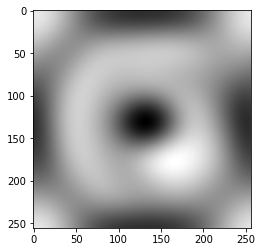

画像の中に 3 個の波が含まれる時にFIRローパスフィルタを適用しました。


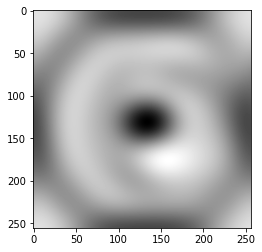

画像の中に 4 個の波が含まれる時にFIRローパスフィルタを適用しました。


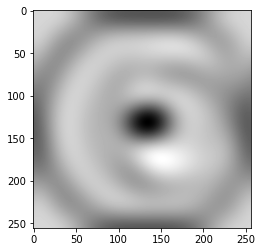

画像の中に 5 個の波が含まれる時にFIRローパスフィルタを適用しました。


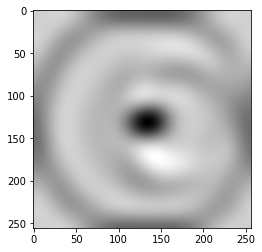

In [22]:
for i in range(2,6):
    print("画像の中に",i,"個の波が含まれる時にFIRローパスフィルタを適用しました。")    
    shifted_f_uv = imgLoad_shiftedFuv('/Users/okadamasayuki/修論実験/Images/G256.png')
    FIR_LowPassFiltered_i_f_xy = imgLoad_FIRLowPassFiltered_shiftedFuv(shifted_f_uv, i)
    plt.imshow(FIR_LowPassFiltered_i_f_xy, cmap='gray')
    plt.show()

In [29]:
# Ellip(楕円)フィルタを作成しています。フィルタのパワースペクトル、位相応答、群遅延、フィルタ画像、伝達関数を表示することが可能です。
# 返り値は、振幅の応答です。これを画像にかけることで、Ellipフィルタを適用した画像を作成することができます。
def Ellip_LowPassFilter(img_square_length, cutoff_frequency):
    from scipy import signal
    # signal.bessel(次元、5、40、カットオフ周波数)  5や40はリップルの指定です。
    b_ellip, a_ellip = signal.ellip(4, 5, 40, cutoff_frequency, 'low', analog=True)
    
    w_ellip, h_ellip = signal.freqs(b_ellip, a_ellip)
    
    # パワースペクトルに変換しています。
    powerSpectrum_ellip = 20 * np.log10(abs(h_ellip))
    
    # 位相応答を計算しています。
    PhaseResponse_ellip = np.unwrap(np.angle(h_ellip))
    
    # 群遅延を計算しています。
    GroupDelay_ellip =-np.diff(np.unwrap(np.angle(h_ellip)))/np.diff(w_ellip)
    
    #### パワースペクトルのグラフを表示します。
    
#     plt.figure(figsize=(7, 5))  # (width, height)
#     plt.xscale("log")
#     plt.plot(w_ellip, powerSpectrum_ellip)
#     plt.title('Elliptic filter frequency response')
#     plt.xlabel('Frequency [Hz]')
#     plt.ylabel('Amplitude [dB]')
#     # 余白が表示されなくなります。
#     plt.margins(0, 0.1)
#     # 灰色のx軸、y軸に並行な線を引きます。
#     plt.grid(which='both', axis='both')
#     # カットオフ周波数に垂線を引きます。
#     plt.axvline(cutoff_frequency, color='green') 
#     plt.show()

    #################
    
    #### 位相応答をグラフで表示します。
    
#     plt.xscale('log')
#     plt.plot(w_ellip, PhaseResponse_ellip)
#     plt.title('Elliptic filter phase response')
#     plt.xlabel('Frequency [Hz]')
#     plt.ylabel('Phase')
#     # 余白が表示されなくなります。
#     plt.margins(0, 0.1)
#     # 灰色のx軸、y軸に並行な線を引きます。
#     plt.grid(which='both', axis='both')
#     # カットオフ周波数に垂線を引きます。
#     plt.axvline(cutoff_frequency, color='green') 
#     plt.show()

    #################
    
    #### 群遅延を表示します。
    
#     plt.plot(w_ellip[1:], GroupDelay_ellip)
#     plt.xscale('log')
#     plt.title('Elliptic filter group delay')
#     plt.xlabel('Frequency [Hz]')
#     plt.ylabel('Group delay')
#     # 余白が表示されなくなります。
#     plt.margins(0, 0.1)
#     # 灰色のx軸、y軸に並行な線を引きます。
#     plt.grid(which='both', axis='both')
#     # カットオフ周波数に垂線を引きます。
#     plt.axvline(cutoff_frequency, color='green')
#     plt.show()
    
    #################
    
    # originは原点の意味です。正方形のimageを扱っています。
    origin_x = img_square_length/2
    origin_y = img_square_length/2
    
    # 画像の原点からの距離を計算して、DistanceFromOriginに2次元リストとして保存します。
    DistanceFromOrigin = []
    
    # 原点からの距離を1次元リストとして保存しています。
    for x in range(img_square_length):
        for y in range(img_square_length):
            DistanceFromOrigin.append(math.sqrt((x - origin_x)**2+(y - origin_y)**2))
    
    # reshapeするためにarray型に変更しました。
    DistanceFromOrigin = np.array(DistanceFromOrigin)
    # 1次元リストを2次元に変更しました。
    DistanceFromOrigin = DistanceFromOrigin.reshape(img_square_length, -1)
    
    w_2D_ellip, h_2D_ellip = signal.freqs(b_ellip, a_ellip, worN=DistanceFromOrigin)
    
    #### ２次元のパワースペクトルを表示します。
    
    # 2次元のパワースペクトルを計算しています。
#     powerSpectrum_2D_ellip = 20 * np.log10(abs(h_2D_ellip))
#     plt.imshow(powerSpectrum_2D_ellip, cmap='gray')
#     plt.colorbar()
#     # メモリを非表示にしています。
#     plt.axis('off')
#     plt.show()
    
    #################
    
    #### 伝達関数の分母を表示しています。分子は1です。
    
#     H = """\
#                  b[0]*(jw)**M + b[1]*(jw)**(M-1) + ... + b[M]
#     H(w) =  ----------------------------------------------------------
#                  a[0]*(jw)**N + a[1]*(jw)**(N-1) + ... + a[N]
#     """

#     print("伝達関数：")
#     print(H)
#     print()
    
#     print("分母のA：")
#     print(a_ellip)
#     print()
    
#     print("分子のB：")
#     print(b_ellip)

    #################
    
    return h_2D_ellip

In [30]:
# EllipLowPassフィルターを適用して、適用した結果の画像を返します。
# imgLoad_shiftedFuvとセットで使うことを想定しています。
def imgLoad_EllipLowPassFiltered_shiftedFuv(original_shifted_f_uv, cutoff_frequency):
    # Ellipフィルタを作成しています。
    h_2D_ellip = Ellip_LowPassFilter(original_shifted_f_uv.shape[0], cutoff_frequency)
    
    # Ellipフィルタを適用しています。
    Ellip_LowPassFiltered_f_uv = np.multiply(original_shifted_f_uv, h_2D_ellip)
    Ellip_LowPassFiltered_unshifted_f_uv = np.fft.fftshift(Ellip_LowPassFiltered_f_uv)
    Ellip_LowPassFiltered_i_f_xy = np.fft.ifft2(Ellip_LowPassFiltered_unshifted_f_uv).real
    
    return Ellip_LowPassFiltered_i_f_xy

画像の中に 2 個の波が含まれる時に楕円ローパスフィルタを適用しました。


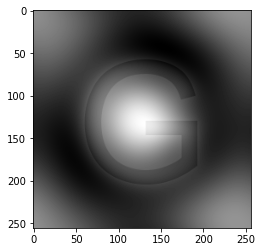

画像の中に 3 個の波が含まれる時に楕円ローパスフィルタを適用しました。


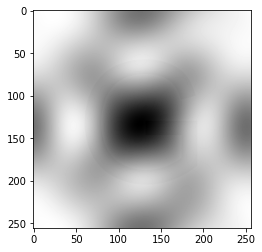

画像の中に 4 個の波が含まれる時に楕円ローパスフィルタを適用しました。


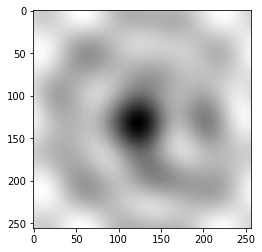

画像の中に 5 個の波が含まれる時に楕円ローパスフィルタを適用しました。


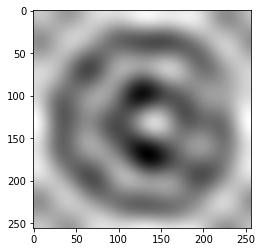

In [31]:
for i in range(2,6):
    print("画像の中に",i,"個の波が含まれる時に楕円ローパスフィルタを適用しました。")
    shifted_f_uv = imgLoad_shiftedFuv('/Users/okadamasayuki/修論実験/Images/G256.png')
    Ellip_LowPassFiltered_i_f_xy = imgLoad_EllipLowPassFiltered_shiftedFuv(shifted_f_uv, i)
    plt.imshow(Ellip_LowPassFiltered_i_f_xy, cmap='gray')
    plt.show()

In [5]:
# Besselフィルタを作成しています。フィルタのパワースペクトル、位相応答、群遅延、フィルタ画像、伝達関数を表示することが可能です。
# 返り値は、振幅の応答です。これを画像にかけることで、Besselフィルタを適用した画像を作成することができます。
def Bessel_LowPassFilter(img_square_length, cutoff_frequency):
    from scipy import signal
    # signal.bessel(次元、カットオフ周波数)
    b_bessel, a_bessel = signal.bessel(4, cutoff_frequency, 'low', analog=True)
    
    w_bessel, h_bessel = signal.freqs(b_bessel, a_bessel)
    
    # パワースペクトルに変換しています。
    powerSpectrum_bessel = 20 * np.log10(abs(h_bessel))
    
    # 位相応答を計算しています。
    PhaseResponse = np.unwrap(np.angle(h_bessel))
    
    # 群遅延を計算しています。
    GroupDelay =-np.diff(np.unwrap(np.angle(h_bessel)))/np.diff(w_bessel)
    
    #### パワースペクトルのグラフを表示します。
    
#     plt.figure(figsize=(7, 5))  # (width, height)
#     plt.xscale("log")
#     plt.plot(w_bessel, powerSpectrum_bessel)
#     plt.title('Bessel filter frequency response')
#     plt.xlabel('Frequency [Hz]')
#     plt.ylabel('Amplitude [dB]')
#     # 余白が表示されなくなります。
#     plt.margins(0, 0.1)
#     # 灰色のx軸、y軸に並行な線を引きます。
#     plt.grid(which='both', axis='both')
#     # カットオフ周波数に垂線を引きます。
#     plt.axvline(cutoff_frequency, color='green') 
#     plt.show()

    #################
    
    #### 位相応答をグラフで表示します。
    
#     plt.xscale('log')
#     plt.plot(w_bessel, PhaseResponse)
#     plt.title('Bessel filter phase response')
#     plt.xlabel('Frequency [Hz]')
#     plt.ylabel('Phase')
#     # 余白が表示されなくなります。
#     plt.margins(0, 0.1)
#     # 灰色のx軸、y軸に並行な線を引きます。
#     plt.grid(which='both', axis='both')
#     # カットオフ周波数に垂線を引きます。
#     plt.axvline(cutoff_frequency, color='green') 
#     plt.show()

    #################
    
    #### 群遅延を表示します。
    
#     plt.plot(w_bessel[1:], GroupDelay)
#     plt.xscale('log')
#     plt.title('Bessel filter group delay')
#     plt.xlabel('Frequency [Hz]')
#     plt.ylabel('Group delay')
#     # 余白が表示されなくなります。
#     plt.margins(0, 0.1)
#     # 灰色のx軸、y軸に並行な線を引きます。
#     plt.grid(which='both', axis='both')
#     # カットオフ周波数に垂線を引きます。
#     plt.axvline(cutoff_frequency, color='green')
#     plt.show()
    
    #################
    
    # originは原点の意味です。正方形のimageを扱っています。
    origin_x = img_square_length/2
    origin_y = img_square_length/2
    
    # 画像の原点からの距離を計算して、DistanceFromOriginに2次元リストとして保存します。
    DistanceFromOrigin = []
    
    # 原点からの距離を1次元リストとして保存しています。
    for x in range(img_square_length):
        for y in range(img_square_length):
            DistanceFromOrigin.append(math.sqrt((x - origin_x)**2+(y - origin_y)**2))
    
    # reshapeするためにarray型に変更しました。
    DistanceFromOrigin = np.array(DistanceFromOrigin)
    # 1次元リストを2次元に変更しました。
    DistanceFromOrigin = DistanceFromOrigin.reshape(img_square_length, -1)
    
    w_2D, h_2D = signal.freqs(b_bessel, a_bessel, worN=DistanceFromOrigin)
    
    #### ２次元のパワースペクトルを表示します。
    
#     # 2次元のパワースペクトルを計算しています。
#     powerSpectrum_2D = 20 * np.log10(abs(h_2D))
#     plt.imshow(powerSpectrum_2D, cmap='gray')
#     plt.colorbar()
#     # メモリを非表示にしています。
#     plt.axis('off')
#     plt.show()
    
    #################
    
    #### 伝達関数の分母を表示しています。分子は1です。
    
#     H = """\
#                  b[0]*(jw)**M + b[1]*(jw)**(M-1) + ... + b[M]
#     H(w) =  ----------------------------------------------------------
#                  a[0]*(jw)**N + a[1]*(jw)**(N-1) + ... + a[N]
#     """

#     print("伝達関数：")
#     print(H)
#     print()
    
#     print("分母のA：")
#     print(a_bessel)
#     print()
    
#     print("分子のB：")
#     print(b_bessel)

    #################
    
    return h_2D

In [6]:
# BesselLowPassフィルターを適用して、適用した結果の画像を返します。
# imgLoad_shiftedFuvとセットで使うことを想定しています。
def imgLoad_BesselLowPassFiltered_shiftedFuv(original_shifted_f_uv, cutoff_frequency):
    # besselフィルタを作成しています。
    h_2D = Bessel_LowPassFilter(original_shifted_f_uv.shape[0], cutoff_frequency)
    
    # besselフィルタを適用しています。
    Bessel_LowPassFiltered_f_uv = np.multiply(original_shifted_f_uv, h_2D)
    Bessel_LowPassFiltered_unshifted_f_uv = np.fft.fftshift(Bessel_LowPassFiltered_f_uv)
    Bessel_LowPassFiltered_i_f_xy = np.fft.ifft2(Bessel_LowPassFiltered_unshifted_f_uv).real
    
    return Bessel_LowPassFiltered_i_f_xy

画像の中に 2 個の波が含まれる時にベッセルローパスフィルタを適用しました。


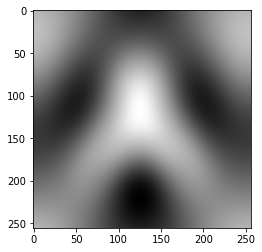

画像の中に 3 個の波が含まれる時にベッセルローパスフィルタを適用しました。


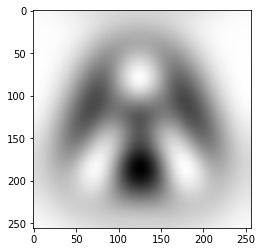

画像の中に 4 個の波が含まれる時にベッセルローパスフィルタを適用しました。


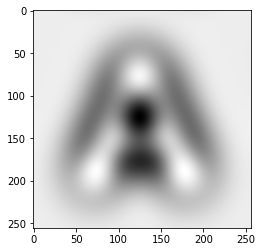

画像の中に 5 個の波が含まれる時にベッセルローパスフィルタを適用しました。


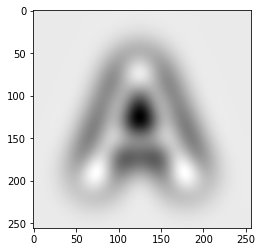

In [108]:
for i in range(2,6):
    print("画像の中に",i,"個の波が含まれる時にベッセルローパスフィルタを適用しました。")
    shifted_f_uv = imgLoad_shiftedFuv('../Images/A256.png')
    Bessel_LowPassFiltered_i_f_xy = imgLoad_BesselLowPassFiltered_shiftedFuv(shifted_f_uv, i)
    plt.imshow(Bessel_LowPassFiltered_i_f_xy, cmap='gray')
    plt.show()

In [7]:
import os
from PIL import Image, ImageDraw, ImageFont

In [8]:
# slider_experiment/Passed_480x480にFIR, besselフィルタを適用した画像を保存します。

# まずは黒地に白文字をのせたoriginal画像を作成し、slider_experiment/original_imagesに保存します。
original_images_path = '/Users/okadamasayuki/Desktop/slider_experiment/original_images'
try:
    os.makedirs(original_images_path)
except FileExistsError:
    print('フォルダーが既に存在したためスルーしました')

In [9]:
# 画像に文字を重ねる
def make_original(square, char, save_path):
    """
        char：重ねる文字
    """
    pix = [0, 0, 0, 255]   # ４つだとRGBA Aはアルファで透明度を意味する
    black_image_matrix = [ [ pix ] * square ] * square
    black_image_array = np.asarray(black_image_matrix)
    black_image_array = black_image_array.astype(np.uint8)  #エラーが出るため、このコードを加えました。
    black_image_pil = Image.fromarray(black_image_array)
    
    draw = ImageDraw.Draw(black_image_pil)  # ImageDrawオブジェクトを作成

    font = ImageFont.truetype("Arial", square)  # フォントを指定、ピクセル単位
    size = font.getsize(char)
    
    # 中心付近に白で文字を描きます。
    draw.text((square/2 - size[0]/2, square/2 - size[1]/2 - square/10), char, font=font, fill='white')
    
    # 画像を保存します。
    black_image_pil.save(save_path+"/"+char+str(square)+"x"+str(square)+".png", 'PNG', quality=100, optimize=True)

In [10]:
alp =["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q","R","S","T","U","V","W","X","Y","Z"]

# 画像は正方形を想定しています。一辺のpixelをsquareで指定しています。
square = 480
for i in range(len(alp)):
    make_original(square, alp[i], original_images_path)

In [11]:
# FIR, besselフィルタを適用した画像を保存するフォルダを作成してます。
Passed_save_path = '/Users/okadamasayuki/Desktop/slider_experiment/Passed_'+str(square)+"x"+str(square)
try:
    os.makedirs(Passed_save_path)
except FileExistsError:
    print('フォルダーが既に存在したためスルーしました')

In [17]:
min_cycle = 1
max_cycle = 20

In [18]:
for alphabet_index in range(len(alp)):
    # フィルタを適用する前の元画像を指定してます。
    original_image = original_images_path+"/"+alp[alphabet_index]+str(square)+"x"+str(square)+".png"
    
    # 画像を二次元フーリエ変換をします。
    shifted_f_uv = imgLoad_shiftedFuv(original_image)
    
    # max_cycleを含んでます。
    for cycle in range(min_cycle, max_cycle+1):
        # FIRローパスフィルタの保存先pathです。
        FIR_file_path               = Passed_save_path + "/"+alp[alphabet_index]+"_"+str(cycle)+"cycle_FIRfilter.png"
        # ベッセルローパスフィルタの保存先pathです。
        bessel_file_path          = Passed_save_path + "/"+alp[alphabet_index]+"_"+str(cycle)+"cycle_Besselfilter.png"
        
        # cycle（画像に何個しましまが含まれるか）と、二次元フーリエ変換の半径を対応させてます。
        radius = cycle_to_radius(cycle)
        
        # FIRフィルタ、besselフィルタの作成と画像への適用をしています。
        FIR_LowPassFiltered_i_f_xy = imgLoad_FIRLowPassFiltered_shiftedFuv(shifted_f_uv, radius)
        Bessel_LowPassFiltered_i_f_xy = imgLoad_BesselLowPassFiltered_shiftedFuv(shifted_f_uv, radius)
        
        # 画像を保存しました。
        plt.imsave(FIR_file_path, FIR_LowPassFiltered_i_f_xy)
        plt.imsave(bessel_file_path, Bessel_LowPassFiltered_i_f_xy)

In [15]:
def cycle_to_radius(cycle):
    radius = cycle
    return radius

In [32]:
# slider_experiment_bessel_ellip/Passed_480x480にbessel, ellipフィルタを適用した画像を保存します。

# まずは黒地に白文字をのせたoriginal画像を作成し、slider_experiment_bessel_ellip/original_imagesに保存します。
original_images_path = '/Users/okadamasayuki/Desktop/slider_experiment_bessel_ellip/original_images'
try:
    os.makedirs(original_images_path)
except FileExistsError:
    print('フォルダーが既に存在したためスルーしました')

In [33]:
# 実験で使用するアルファベットです。
alp =["B","D","F","M","R"]

# 画像は正方形を想定しています。一辺のpixelをsquareで指定しています。
square = 480
for i in range(len(alp)):
    make_original(square, alp[i], original_images_path)

In [34]:
# bessel, ellipフィルタを適用した画像を保存するフォルダを作成してます。
Passed_save_path = '/Users/okadamasayuki/Desktop/slider_experiment_bessel_ellip/Passed_'+str(square)+"x"+str(square)
try:
    os.makedirs(Passed_save_path)
except FileExistsError:
    print('フォルダーが既に存在したためスルーしました')

In [37]:
min_cycle = 1
max_cycle = 15

In [38]:
for alphabet_index in range(len(alp)):
    # フィルタを適用する前の元画像を指定してます。
    original_image = original_images_path+"/"+alp[alphabet_index]+str(square)+"x"+str(square)+".png"
    
    # 画像を二次元フーリエ変換をします。
    shifted_f_uv = imgLoad_shiftedFuv(original_image)
    
    # max_cycleを含んでます。
    for cycle in range(min_cycle, max_cycle+1):
        # ellipローパスフィルタの保存先pathです。
        ellip_file_path              = Passed_save_path + "/"+alp[alphabet_index]+"_"+str(cycle)+"cycle_Ellipfilter.png"
        # ベッセルローパスフィルタの保存先pathです。
        bessel_file_path          = Passed_save_path + "/"+alp[alphabet_index]+"_"+str(cycle)+"cycle_Besselfilter.png"
        
        # cycle（画像に何個しましまが含まれるか）と、二次元フーリエ変換の半径を対応させてます。
        radius = cycle_to_radius(cycle)
        
        # ellipフィルタ、besselフィルタの作成と画像への適用をしています。
        Ellip_LowPassFiltered_i_f_xy = imgLoad_EllipLowPassFiltered_shiftedFuv(shifted_f_uv, radius)
        Bessel_LowPassFiltered_i_f_xy = imgLoad_BesselLowPassFiltered_shiftedFuv(shifted_f_uv, radius)
        
        # 画像を保存しました。
        plt.imsave(ellip_file_path, Ellip_LowPassFiltered_i_f_xy)
        plt.imsave(bessel_file_path, Bessel_LowPassFiltered_i_f_xy)

In [39]:
# パワースペクトル、位相応答、群遅延のそれぞれで、besselとellipを重ねる

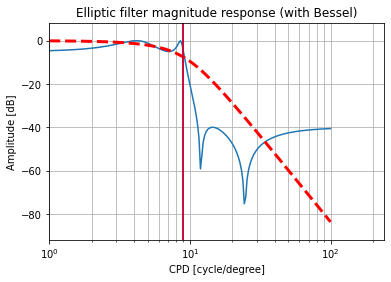

In [85]:
# パワースペクトルを重ねて表示します。
cutoff_frequency_ellip = 9
cutoff_frequency_bessel = 9
order = 4
b_ellip, a_ellip = signal.ellip(order, 5, 40, cutoff_frequency_ellip, 'low', analog=True)
w_ellip, h_ellip = signal.freqs(b_ellip, a_ellip)
powerSpectrum_ellip = 20 * np.log10(abs(h_ellip))

b_bessel, a_bessel = signal.bessel(order, cutoff_frequency_bessel, 'low', analog=True)
w_bessel, h_bessel = signal.freqs(b_bessel, a_bessel)
powerSpectrum_bessel = 20 * np.log10(abs(h_bessel))

plt.plot(w_ellip, powerSpectrum_ellip)
plt.plot(w_bessel, powerSpectrum_bessel, color='red', ls='dashed', lw=3)
plt.xscale('log')
plt.title('Elliptic filter magnitude response (with Bessel)')
plt.xlabel('CPD [cycle/degree]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(cutoff_frequency_ellip, color='blue')  # cutoff frequency(ellip)
plt.axvline(cutoff_frequency_bessel, color='red')  # cutoff frequency(bessel)
plt.xlim(1,240)
plt.show()

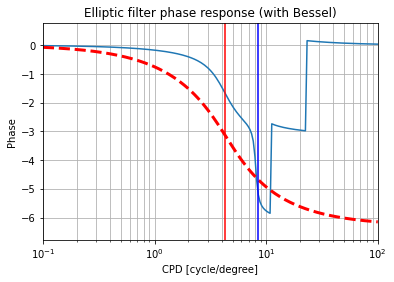

In [86]:
# 位相応答を重ねて表示します。
cutoff_frequency_ellip = 8.385
cutoff_frequency_bessel = 4.245
order = 4
b_ellip, a_ellip = signal.ellip(order, 5, 40, cutoff_frequency_ellip, 'low', analog=True)
w_ellip, h_ellip = signal.freqs(b_ellip, a_ellip)
PhaseResponse_ellip = np.unwrap(np.angle(h_ellip))
    
# b_bessel, a_bessel = signal.bessel(order, cutoff_frequency, 'low', analog=True)
b_bessel, a_bessel = signal.bessel(order, cutoff_frequency_bessel, 'low', analog=True)
w_bessel, h_bessel = signal.freqs(b_bessel, a_bessel)
PhaseResponse_bessel = np.unwrap(np.angle(h_bessel))

plt.xscale('log')
plt.plot(w_ellip, PhaseResponse_ellip)
plt.plot(w_bessel, PhaseResponse_bessel, color='red', ls='dashed', lw=3)
plt.title('Elliptic filter phase response (with Bessel)')
plt.xlabel('CPD [cycle/degree]')
plt.ylabel('Phase')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(cutoff_frequency_bessel, color='red')  # cutoff frequency(bessel)
plt.axvline(cutoff_frequency_ellip, color='blue')  # cutoff frequency(ellip)
plt.show()

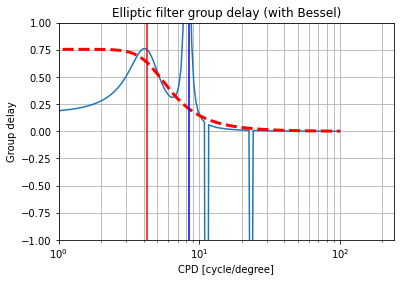

In [87]:
# 群遅延を重ねて表示します。
cutoff_frequency_ellip = 8.385
cutoff_frequency_bessel = 4.245
order = 4
b_ellip, a_ellip = signal.ellip(order, 5, 40, cutoff_frequency_ellip, 'low', analog=True)
w_ellip, h_ellip = signal.freqs(b_ellip, a_ellip)
GroupDelay_ellip =-np.diff(np.unwrap(np.angle(h_ellip)))/np.diff(w_ellip)
    
# b_bessel, a_bessel = signal.bessel(order, cutoff_frequency, 'low', analog=True)
b_bessel, a_bessel = signal.bessel(order, cutoff_frequency_bessel, 'low', analog=True)
w_bessel, h_bessel = signal.freqs(b_bessel, a_bessel)
GroupDelay_bessel =-np.diff(np.unwrap(np.angle(h_bessel)))/np.diff(w_bessel)

plt.xscale('log')
plt.plot(w_ellip[1:], GroupDelay_ellip)
plt.plot(w_bessel[1:], GroupDelay_bessel, color='red', ls='dashed', lw=3)
plt.title('Elliptic filter group delay (with Bessel)')
plt.xlabel('CPD [cycle/degree]')
plt.ylabel('Group delay')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(cutoff_frequency_bessel, color='red')  # cutoff frequency(bessel)
plt.axvline(cutoff_frequency_ellip, color='blue')  # cutoff frequency(ellip)
plt.xlim(1,240)
plt.ylim(-1, 1)
plt.show()